In [20]:
# how to get group's id

import urllib.request
import json

version = '5.92'
token =
'3b4498373b4498373b449837893b2d5a9633b443b44983767eceaa69c02cdeb90d9da85'
group = 'wonderzine'


def object_id_getter():
    req = urllib.request.Request('https://api.vk.com/method/utils.resolveScreenName?screen_name=%s&access_token=%s&v=%s' % (group, token, version))
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result)
    return data['response']['object_id']

object_id_getter()


54218032

In [21]:
from pymystem3 import Mystem

def lemmatize(thing):
    m = Mystem()
    lemmas = m.lemmatize(thing)
    lemmatized = ''.join(lemmas)
    return lemmatized

In [22]:
from pymystem3 import Mystem


def lemmatize(thing):
    m = Mystem()
    lemmas = m.lemmatize(thing)
    lemmatized = ''.join(lemmas)
    return lemmatized
    

In [24]:
import sqlite3
import re
import datetime


def db_posts():
    conn = sqlite3.connect('posts_11.db')
    c = conn.cursor()
    c.execute('CREATE TABLE IF NOT EXISTS posts(post_id integer, date iteger, weekday integer, post_text text, text_lemmatized text, word_number integer)')
    offsets = [0, 100, 200, 300]
    for i in offsets:
        req = urllib.request.Request('https://api.vk.com/method/wall.get?count=30&domain=%s&access_token=%s&v=%s&offset=%s'  % (group, token, version, i))
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result)
        for item in data['response']['items']:
            post_id = item['id']
            date = datetime.date.fromtimestamp(item['date'])
            weekday = date.weekday()
            text = item['text']
            group_mentions = re.sub(' \[.+?\]', '', text)
            links = re.sub('http:\/\/amp\.gs\/.+', '', group_mentions)
            enter = re.sub('\n', '', links)
            text_lemmatized = lemmatize(enter)
            word_number = len(re.findall(r'\w+', enter))
            c.execute('INSERT INTO posts VALUES (?, ?, ?, ?, ?, ?)', (post_id, date, weekday, enter, text_lemmatized, word_number))
            conn.commit()
    conn.close()

db_posts()


In [25]:
def db_comments(posts_db_name):
    owner_id = '-' + str(object_id_getter())
    offsets = [0, 100, 200, 300]

    conn = sqlite3.connect(posts_db_name)
    c = conn.cursor()
    post_ids = [item[0] for item in c.execute('SELECT post_id FROM posts')]
    conn.close

    conn = sqlite3.connect('comments_1.db')
    c = conn.cursor()
    c.execute('CREATE TABLE IF NOT EXISTS comments(post_id integer, comment_id integer, text text, word_number integer, commentator_id integer)')
    for off in offsets:
        for item in post_ids:
            req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id=%s&post_id=%s&access_token=%s&v=%s&offset=%s'  % (owner_id, item, token, version, off))
            response = urllib.request.urlopen(req)
            result = response.read().decode('utf-8')
            data = json.loads(result)
            n = data['response']['count']
            try:
                for i in range(0, n-1):
                    comment_id = data['response']['items'][i]['id']
                    text = data['response']['items'][i]['text']
                    commentator_id = data['response']['items'][i]['from_id']
                    word_number = len(re.findall(r'\w+', text))
                    c.execute('INSERT INTO comments VALUES (?, ?, ?, ?, ?)', (item, comment_id, text, word_number, commentator_id))
                    conn.commit()
            except:
                pass
    conn.close

db_comments('posts_11.db')


In [26]:
def db_people(comments_db_name):
    conn = sqlite3.connect(comments_db_name)
    c = conn.cursor()
    people_ids = [item[0] for item in c.execute('SELECT DISTINCT commentator_id FROM comments')]
    conn.close

    conn = sqlite3.connect('commentators_1.db')
    c = conn.cursor()
    c.execute('CREATE TABLE IF NOT EXISTS commentators(commentator_id integer, name text, followers integer, city text)')
    for item in people_ids:
        req = urllib.request.Request('https://api.vk.com/method/users.get?user_ids=%s&access_token=%s&v=%s&fields=counters,city'  % (item, token, version))
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result)
        name = data['response'][0]['first_name'] + ' ' + data['response'][0]['last_name']
        try:
            city = data['response'][0]['city']['title']
        except:
            city = 'None'
        try:
            followers = data['response'][0]['counters']['followers']
        except:
            followers = 'None'
        c.execute('INSERT INTO commentators VALUES (?, ?, ?, ?)', (item, name, followers, city))
        conn.commit()
    conn.close()

db_people('comments_1.db')


In [27]:
import collections


def top_words(posts_db_name, stoplist, text):
    # open the database
    conn = sqlite3.connect(posts_db_name)
    c = conn.cursor()
    # a huge list of all words from all texts, without stop words
    wordlist = []
    for item in c.execute('SELECT %s FROM posts' %(text)):
        for word in item[0].split():
            w = re.search('\w+', word)
            if w and w.group().lower() not in stoplist:
                wordlist.append(w.group().lower())
    counter = collections.Counter(wordlist)
    freq_list = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    return freq_list


In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from heapq import nlargest


def plotMaker(freq_list, pic_name):
    style.use('ggplot')
    X = [word[0] for word in freq_list][:20]  # x-labels
    x = range(len(X))  # x-data
    Y = [count[1] for count in freq_list][:20]  # y-data

    colors = sns.color_palette('spring', max(Y))

    plt.figure(figsize=(20, 10), dpi=200)
    plt.bar(x, Y, color=colors)

    plt.title('\nTop-20 Words\n', fontsize=25)
    plt.ylabel('Number of words\n', fontsize=20)
    plt.xlabel('\nWords', fontsize=20)
    plt.xticks(x, X, rotation=90)
#     +save pics
    plt.savefig(pic_name + '.png', dpi=100)
    plt.show()
    

In [29]:
import statistics


def postLengthVSavgCommentLength(posts_db_name, comments_db_name):
    posts = {}  
    conn = sqlite3.connect(posts_db_name)
    c = conn.cursor()
    c.execute('SELECT post_id, word_number FROM posts')
    a = c.fetchall()    
    conn.close()
    
    conn = sqlite3.connect(comments_db_name)
    c = conn.cursor()
    c.execute('SELECT post_id, word_number FROM comments')
    b = c.fetchall()
    for item in a: #for every pair of post_id-word_number
        comm_list = []
        for pair in b: #for every pair of post_id for a comment-word_number          
            if item[0] == pair[0]:
                comm_list.append(pair[1])
                posts[item[1]] = int(statistics.mean(comm_list))
    conn.close()
    return posts


In [30]:
from scipy.interpolate import interp1d 


def avgPlot(counter):
    post_length = [c[1] for c in sorted(counter.items(), key=lambda x: x[0], reverse=False)]
    comment_length = sorted([num for num in counter])
#     print(post_length, comment_length)
    f = interp1d(comment_length, [comment_length+0.5 for comment_length in post_length], kind='quadratic')
    x_new = np.linspace(7, 36) # тут нужны min и max по оси x
    y_smooth = f(x_new)
    plt.plot(x_new, y_smooth, c='xkcd:moss', linewidth='3')
#     print(post_length, comment_length)
    plt.title('\nPost Length VS Avegage Comment Length\n', fontsize=20)
    plt.ylabel('Average Comment length\n',  fontsize=16)
    plt.xlabel('\nPost Length',  fontsize=18)
#     plt.xticks(x, city_labs, rotation=90)
    plt.savefig('PLVSACL.png', dpi=100)
    plt.show()


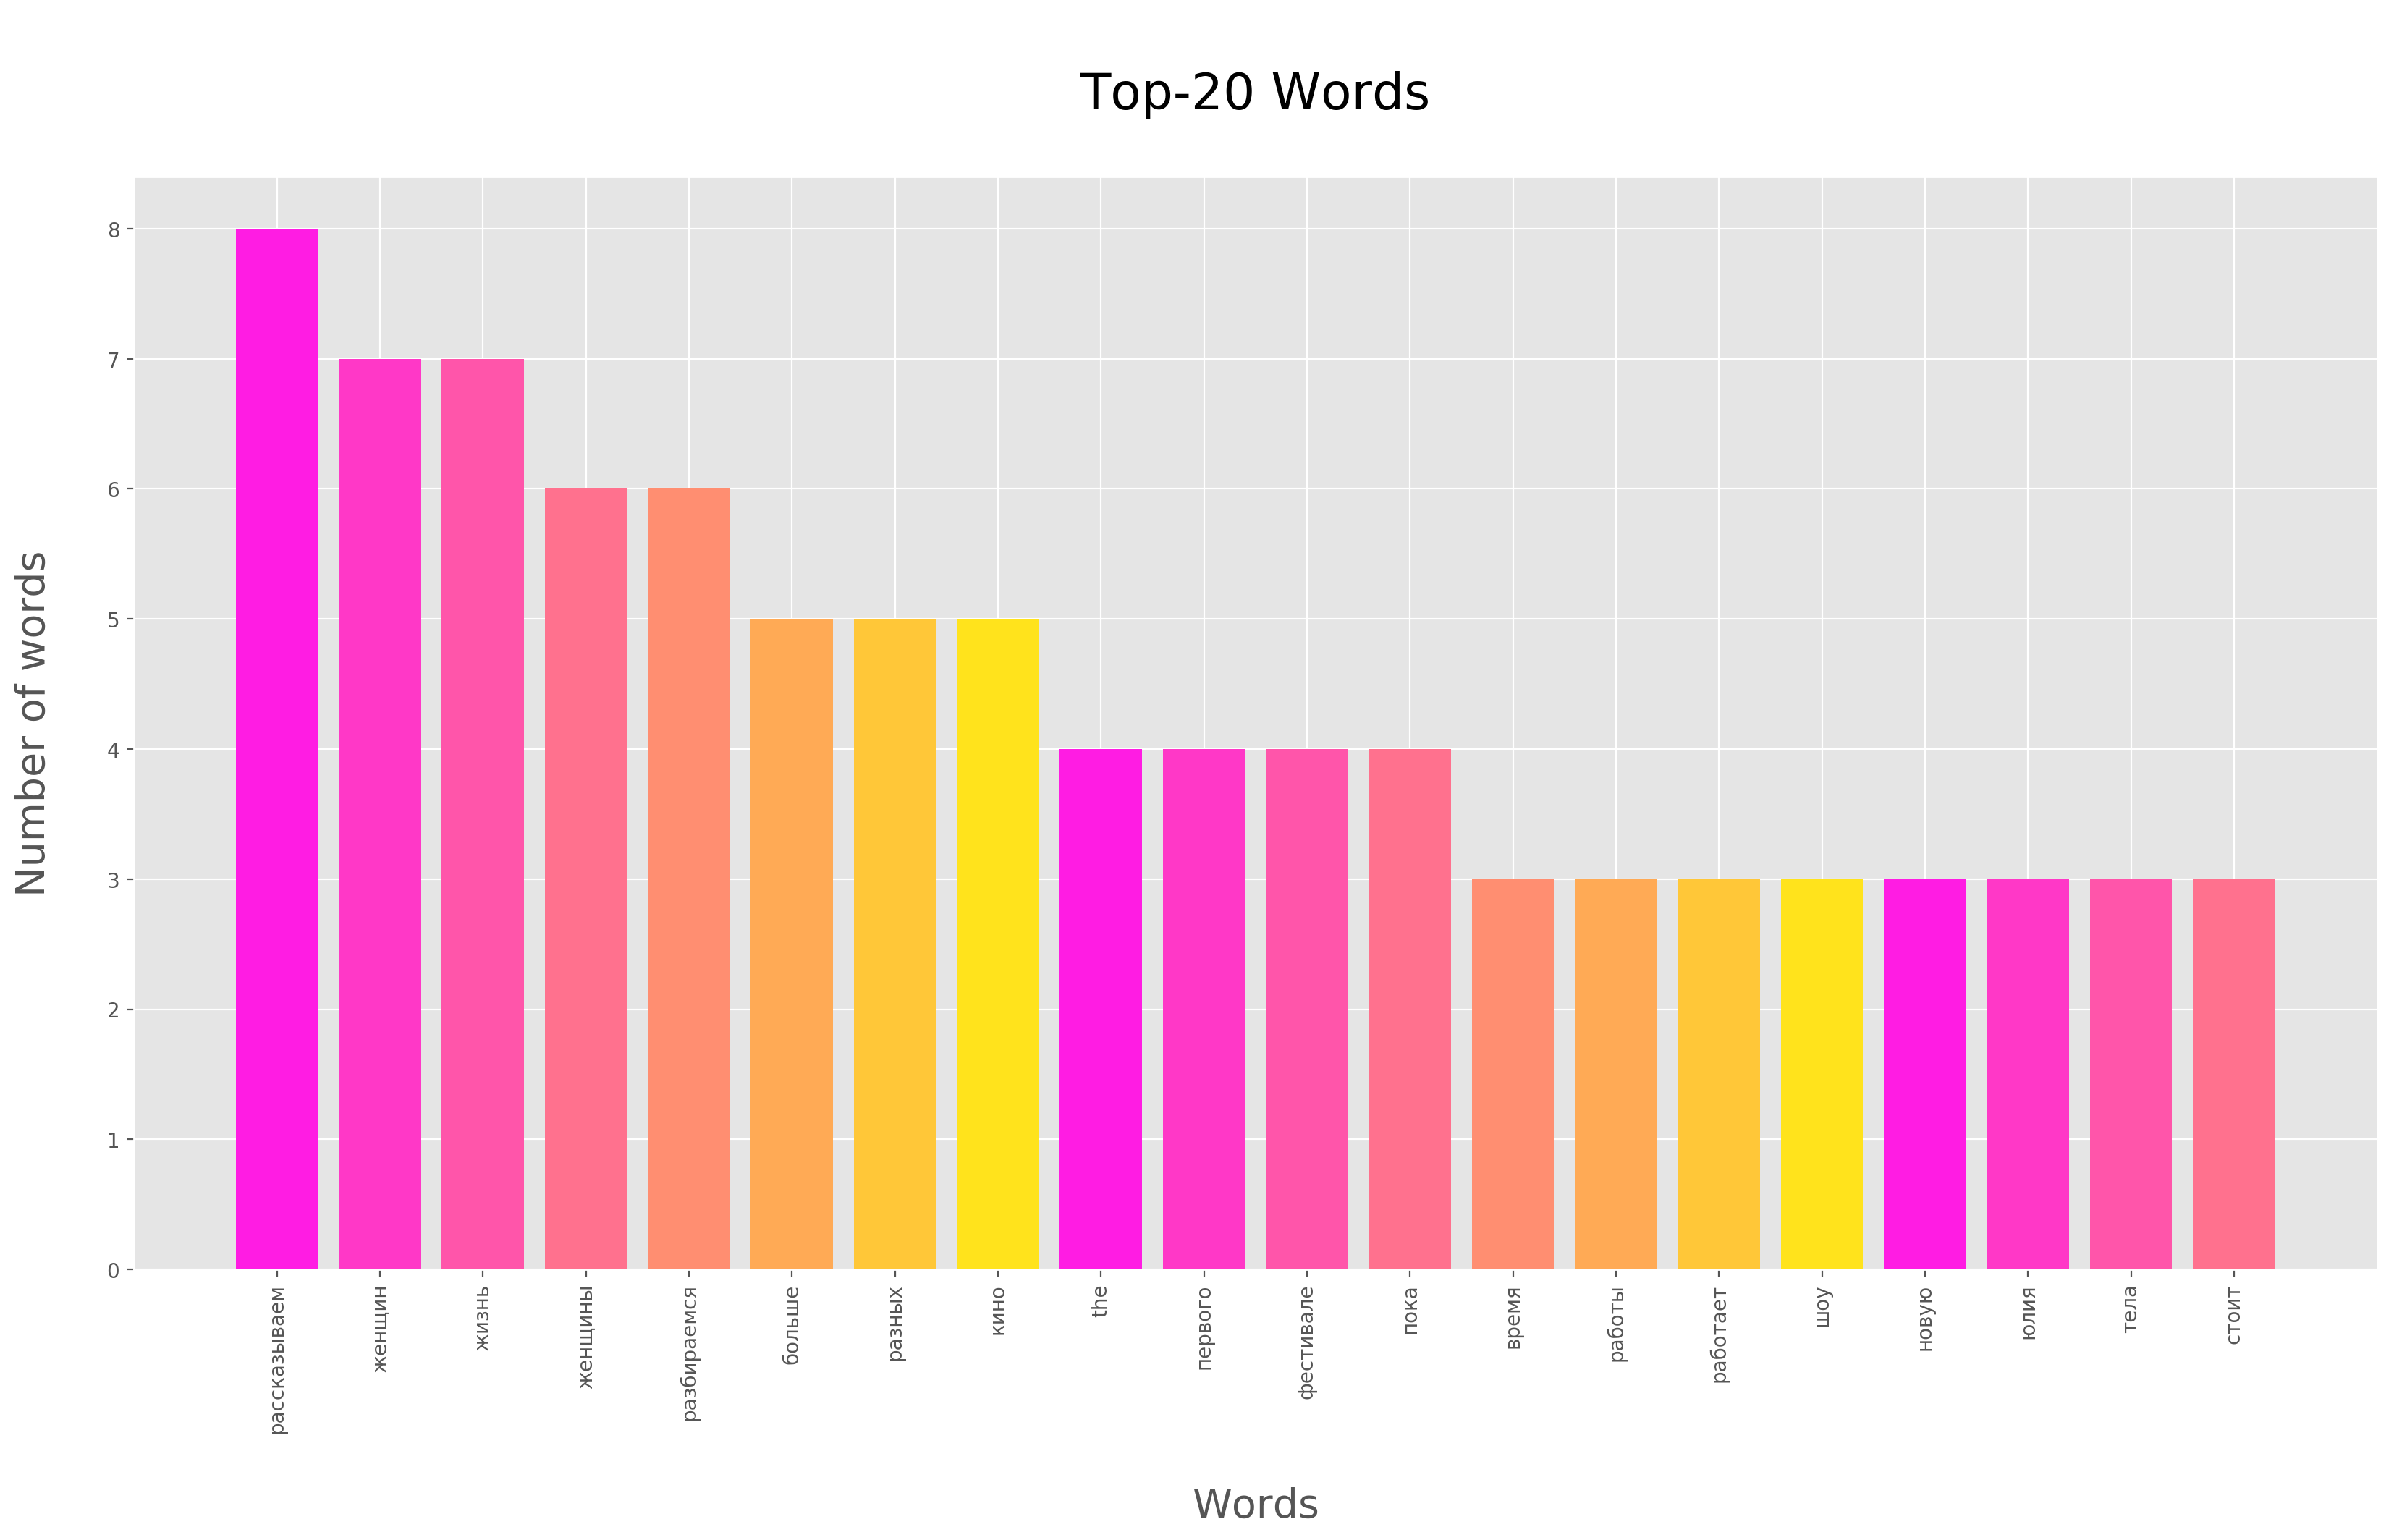

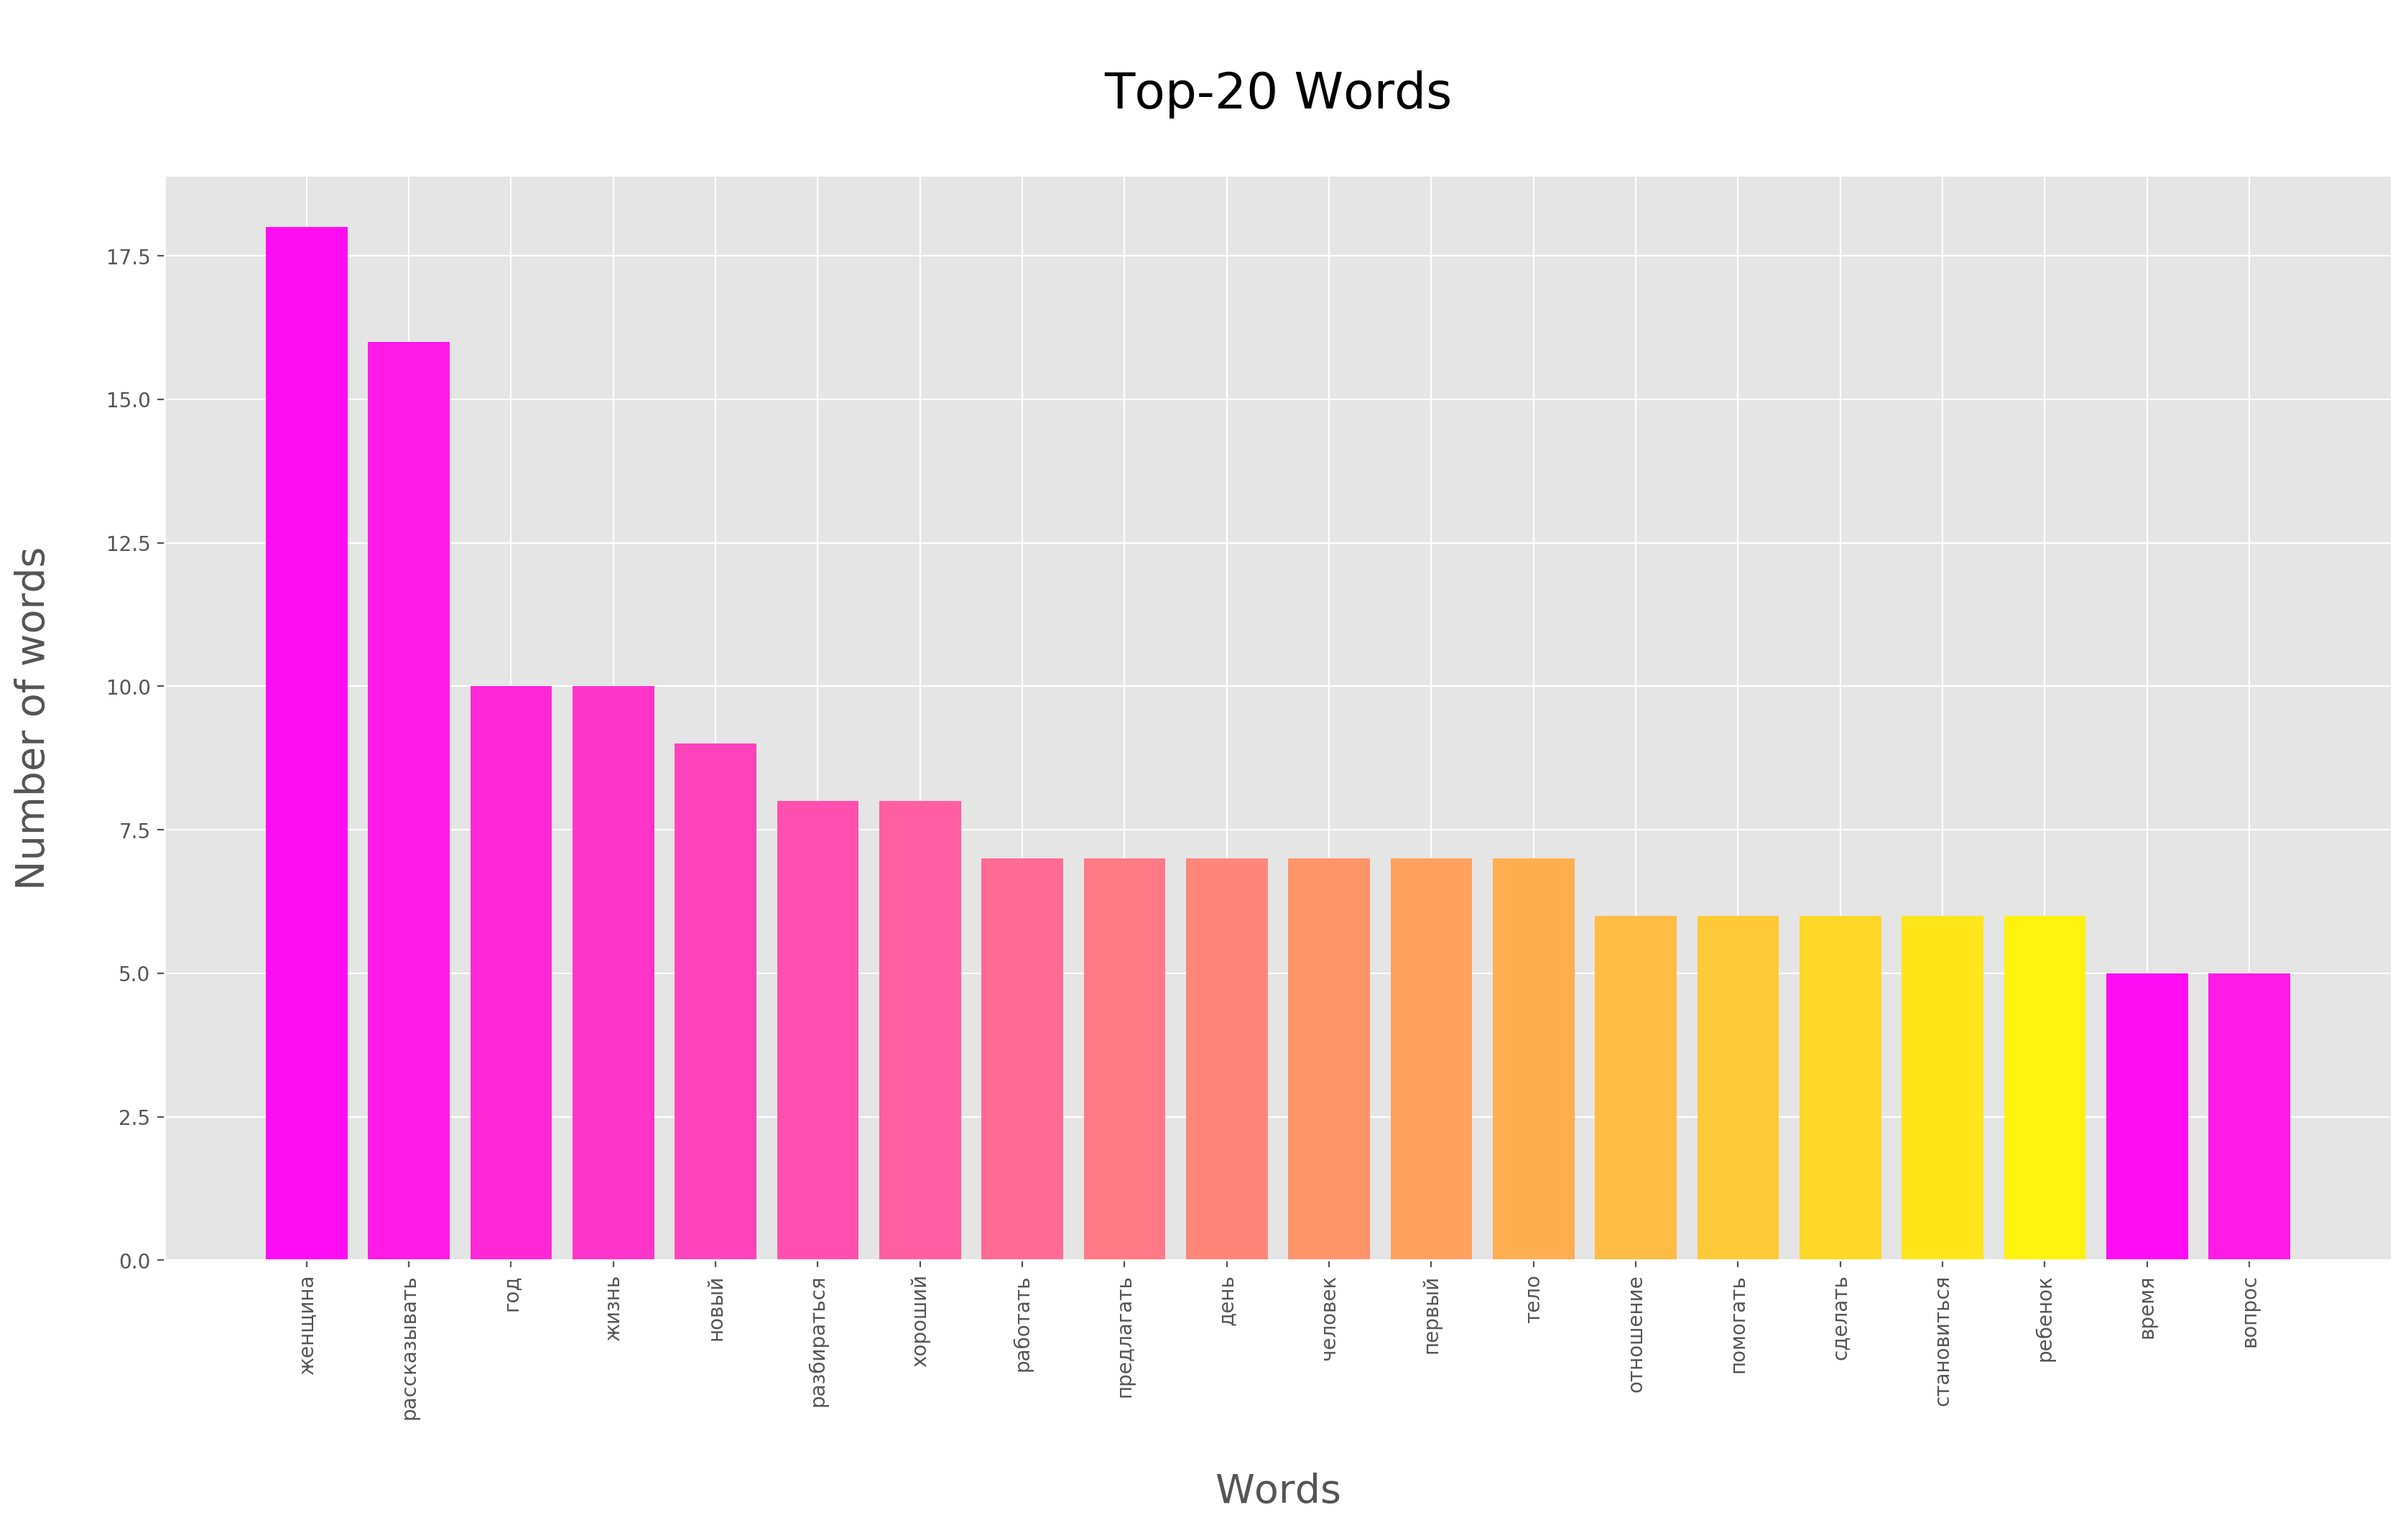

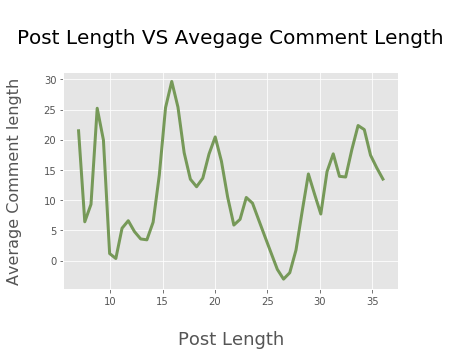

In [31]:


def main():
    plotMaker(top_words('posts_11.db', stoplistMaker(), 'post_text'), 'non-lemmatized')
    plotMaker(top_words('posts_11.db', stoplistMaker(), 'text_lemmatized'), 'lemmatized')
    avgPlot(postLengthVSavgCommentLength('posts_11.db', 'comments_1.db'))

if __name__ == '__main__':
    main()    
    